In [1]:
# Some settings
# Which pre-trained model to use.
# See https://huggingface.co/models for options.
checkpoint = "microsoft/deberta-v3-small"

# How much training data to use.
# 1.0 uses the whole training set but it can take a bit of time to train.
train_data_sample_ratio = 0.1

# Example sentence to use
# We print out predictions for this sentence before and after training
example_sentence = "this was by far the best movie of the year"
     

In [25]:
# Import the libraries
import matplotlib.pyplot as plt
import pickle
import torch
import evaluate

from torch.utils.data import DataLoader
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AdamW
from transformers import AutoModelForSequenceClassification
from transformers import get_scheduler
from tqdm.auto import tqdm

In [3]:
# Checking whether you are running on CPU or GPU.
# If the output here says "cuda" then it's running on GPU. Otherwise it's probably CPU.
# In order to run your code in Colab on the GPU, go to Edit -> Notebook settings -> Hardware accelerator and set it to "GPU".
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [4]:
# Loading the pretrained model
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
model = model.to(device)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
import pandas as pd

In [6]:
train_dataset_path ="../dataset/dpm_pcl_train.csv"
train_dataset = pd.read_csv(train_dataset_path)

val_dataset_path ="../dataset/dpm_pcl_val.csv"
val_dataset = pd.read_csv(val_dataset_path)

test_dataset_path ="../dataset/dpm_pcl_test.csv"
test_dataset = pd.read_csv(test_dataset_path)

train_dataset.head()

,par_id,art_id,keyword,country,text,orig_label
0,5825,@@9438566,in-need,au,Describing local police as under resourced and...,0
1,7171,@@1934487,hopeless,ng,The only force capable of stopping them is the...,3
2,680,@@9525972,in-need,nz,Plans by the Government to return to bulk fund...,0
3,4906,@@22596758,refugee,bd,"New figures reveal that more than 48,000 Rohin...",0
4,8180,@@13717053,migrant,ph,"He then listed several immigrants , mostly fro...",0


In [7]:
train_dataset["label"] = train_dataset["orig_label"].apply(lambda x : 0 if (x == 0 or x == 1) else 1)
val_dataset["label"] = val_dataset["orig_label"].apply(lambda x : 0 if (x == 0 or x == 1) else 1)
test_dataset["label"] = test_dataset["orig_label"].apply(lambda x : 0 if (x == 0 or x == 1) else 1)

train_dataset.loc[train_dataset["text"].isna(), "text"] = ""
val_dataset.loc[val_dataset["text"].isna(), "text"] = ""
test_dataset.loc[test_dataset["text"].isna(), "text"] = ""

train_dataset = train_dataset.drop(['par_id', 'art_id', 'keyword', 'country', 'orig_label'], axis=1)
val_dataset = val_dataset.drop(['par_id', 'art_id', 'keyword', 'country', 'orig_label'], axis=1)
test_dataset = test_dataset.drop(['par_id', 'art_id', 'keyword', 'country', 'orig_label'], axis=1)

train_dataset.head()

,text,label
0,Describing local police as under resourced and...,0
1,The only force capable of stopping them is the...,1
2,Plans by the Government to return to bulk fund...,0
3,"New figures reveal that more than 48,000 Rohin...",0
4,"He then listed several immigrants , mostly fro...",0


In [8]:
# Perform tokenization
tokenizer = AutoTokenizer.from_pretrained(checkpoint, model_max_length=512)

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=512)

raw_datasets_train = Dataset.from_pandas(train_dataset[['text', 'label']])
raw_datasets_val = Dataset.from_pandas(val_dataset[['text', 'label']])
raw_datasets_test = Dataset.from_pandas(test_dataset[['text', 'label']])

tokenized_datasets_train = raw_datasets_train.map(tokenize_function, batched=True, remove_columns=['text'])
tokenized_datasets_val = raw_datasets_val.map(tokenize_function, batched=True, remove_columns=['text'])
tokenized_datasets_test = raw_datasets_test.map(tokenize_function, batched=True, remove_columns=['text'])

# DataCollatorWithPadding constructs batches that are padded to the length of the longest sentence in the batch
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

train_dataloader = DataLoader(
    tokenized_datasets_train, shuffle=True, batch_size=8, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets_val, batch_size=8, collate_fn=data_collator
)
test_dataloader = DataLoader(
    tokenized_datasets_test, batch_size=8, collate_fn=data_collator
)


/vol/bitbucket/gd221/nlp/NLP-CW/venv/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Map: 100%|██████████| 2094/2094 [00:00<00:00, 3979.35 examples/s]


In [9]:
next(iter(train_dataloader))

{'input_ids': tensor([[    1, 66194,   292,  ...,     0,     0,     0],
        [    1,   512,   382,  ...,     0,     0,     0],
        [    1,  1258,   265,  ...,     0,     0,     0],
        ...,
        [    1,   344,   299,  ...,     0,     0,     0],
        [    1,   329,   326,  ...,     0,     0,     0],
        [    1,   307,   879,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([0, 0, 0, 0, 1, 0, 0, 0])}

In [10]:
# Printing out the shapes in one batch
example_batch = None
for batch in train_dataloader:
    example_batch = batch
    break

print({k: v.shape for k, v in example_batch.items()})


# Then printing out the loss, output shape and output values from one batch.
outputs = model(**example_batch.to(device))
print("output.loss: ", outputs.loss)
print("output.logits.shape: ", outputs.logits.shape)
print("output.logits: ", outputs.logits)

# Generating predictions for an example sentence.
# Haven't trained the model yet so these will be random.
def print_example_predictions(example_sentence, example_model):
    _e = tokenize_function({"text": example_sentence})
    _k = {k: torch.tensor([_e[k]]).to(device) for k in _e}
    model.eval()
    example_outputs = model(**_k)
    example_logits = example_outputs.logits.cpu().detach().numpy()
    example_probabilities = torch.nn.functional.softmax(example_outputs.logits, dim=1).cpu().detach().numpy()
    print(example_probabilities)
    print("Example sentence: ", example_sentence)
    print("Predicted logits: ", example_logits)
    print("Predicted probabilities: ", example_probabilities)
    print("Prediction: ", "negative" if example_probabilities[0][0] > example_probabilities[0][1] else "positive")

print_example_predictions(example_sentence, model)

{'input_ids': torch.Size([8, 512]), 'token_type_ids': torch.Size([8, 512]), 'attention_mask': torch.Size([8, 512]), 'labels': torch.Size([8])}
output.loss:  tensor(0.8246, device='cuda:0', grad_fn=<NllLossBackward0>)
output.logits.shape:  torch.Size([8, 2])
output.logits:  tensor([[-0.1926,  0.0512],
        [-0.1955,  0.0574],
        [-0.1920,  0.0496],
        [-0.1950,  0.0539],
        [-0.1930,  0.0525],
        [-0.1944,  0.0534],
        [-0.1957,  0.0593],
        [-0.1950,  0.0503]], device='cuda:0', grad_fn=<AddmmBackward0>)
[[0.43640986 0.5635901 ]]
Example sentence:  this was by far the best movie of the year
Predicted logits:  [[-0.19621426  0.05953109]]
Predicted probabilities:  [[0.43640986 0.5635901 ]]
Prediction:  positive


In [19]:
# Setting up model training for fine-tuning
lr = 5e-5
optimizer = AdamW(model.parameters(), lr=lr)

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

/vol/bitbucket/gd221/nlp/NLP-CW/venv/lib/python3.12/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
train_losses, val_losses = [], []

# Running the training
progress_bar = tqdm(range(num_training_steps))
for epoch in range(num_epochs):
    train_loss, val_loss = 0, 0
    
    # Setting the model to training mode
    model.train()
    
    for batch in train_dataloader:
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        train_loss += loss.item()
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    
    train_loss /= len(train_dataloader.dataset)
    train_losses.append(train_loss)
    
    # Setting the model to evaluation mode
    model.eval()
    
    for batch in eval_dataloader:
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            loss = outputs.loss
            val_loss += loss.item()
    
    val_loss /= len(eval_dataloader.dataset)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch + 1}: train_loss = {train_loss}, val_loss = {val_loss}")

 33%|███▎      | 839/2514 [03:09<2:19:32,  5.00s/it]

Epoch 1: train_loss = 0.0344521298767554, val_loss = 0.031961599982051704


 67%|██████▋   | 1677/2514 [06:21<1:10:39,  5.07s/it]

Epoch 2: train_loss = 0.023378431369835483, val_loss = 0.030918887265360177


100%|██████████| 2514/2514 [09:18<00:00,  5.20it/s]  

Epoch 3: train_loss = 0.012931890467411158, val_loss = 0.027914143513971524


In [23]:
# Plots the training and validation losses
def plot_train_val_losses(train_losses, val_losses, num_epochs, lr):
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label="train loss")
    plt.plot(val_losses, label="validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Number epochs: {num_epochs}, lr: {lr}")
    plt.grid()
    plt.show()
    
# Save the model's state
def save_model(model, filename):
    model_dir = "./models/"
    with torch.no_grad():
        torch.save(model.state_dict(), model_dir + filename)
    
# Save the model hyperparameters and losses for later comparison
def 

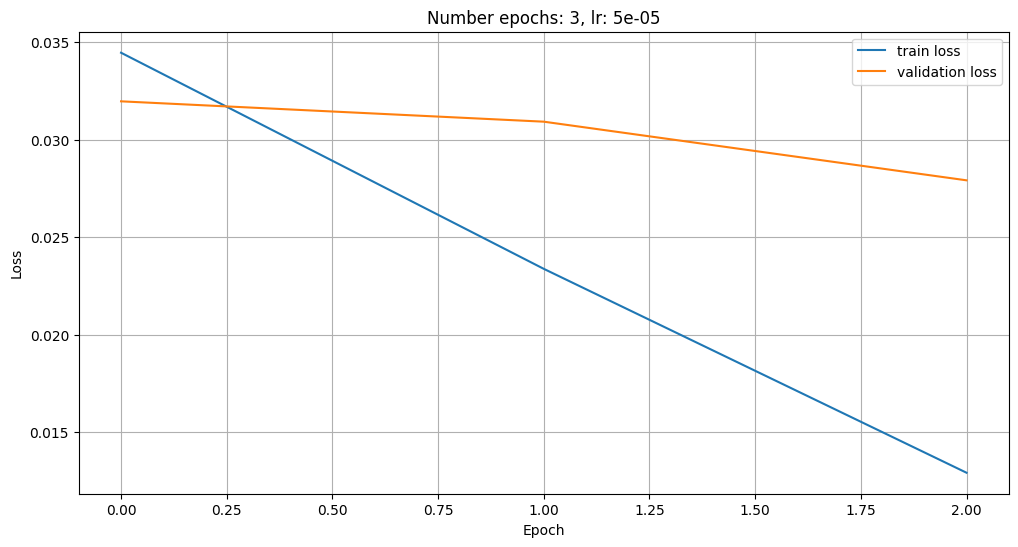

In [24]:
plot_train_val_losses(train_losses, val_losses, num_epochs, lr)
save_losses(train_losses, val_losses, )

In [14]:
# Setting the model to evaluation mode
model.eval()

# Running evaluation
metric = evaluate.load("f1")
for batch in tqdm(test_dataloader):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

print(metric.compute())

{'f1': 0.5100286532951289}


In [16]:
# Getting predictions for the example sentence again, now that we have trained the model
print_example_predictions(example_sentence, model)

[[0.9951402  0.00485979]]
Example sentence:  this was by far the best movie of the year
Predicted logits:  [[ 2.9714403 -2.3504477]]
Predicted probabilities:  [[0.9951402  0.00485979]]
Prediction:  negative
